# Volatilty-timing strategy
*Xiaoqiong(Joan) Zhang*

*Asset Allocation Model based on high-frequency realized variances.*

*The optimal weight $y=\frac{E(R)}{A*Var(R)}$*
* *We predict both E(R) and Var(R)*

### Simple Model

From Moreira and Muir, we can use the following equation to study the relationship between lagged volatility and current volatility.

$$R_{t+1}^2 = \alpha + \beta RV_t + \epsilon_{t+1}$$

For this homework set, if we want to consider the possibility that RV also predicts excess returns, the regression equation will be:

$$R_{t+1} = \alpha + \beta RV_t + \epsilon_{t+1}$$


* $R$ is the excess return on SPY 
* $RV$ is the 5-minute realized variance from the Oxford-Mann dataset (the rv5 column).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels.formula.api as smf

In [2]:
# Load data
data = pd.read_csv('oxfordmanrealizedvolatilityindices.csv',parse_dates=[0])
spy = pd.read_csv('SPY.csv',parse_dates=[0],index_col=[0])
vix = pd.read_csv('^VIX.csv',parse_dates=[0],index_col=[0])
irx = pd.read_csv('^IRX.csv',parse_dates=[0],index_col=[0])

#### Functions Preparation

In [3]:
def define_weight(w,max_weight,min_weight):
    w = np.minimum(w, max_weight)
    w = np.maximum(w, min_weight)
    return w

In [4]:
def Maximum_DD(data):
    # Calculate daily MDD
    window = len(data)
    Roll_Max = data.rolling(window,min_periods=1).max()
    Daily_DD = data/Roll_Max - 1.0
    Max_Daily_DD = Daily_DD.rolling(window,min_periods=1).min()
    MaxDD = Max_Daily_DD.min()
    return MaxDD

def describePerformance(Data,alpha=0.05):
    
    value = (1+Data).cumprod()
    
    x = Data.describe()
    x.drop(['count','25%','75%'], inplace=True)
    
    x.loc['ann_std'] = x.loc['std']*np.sqrt(250)
    x.loc['ann_ret (%)'] = (((1+Data).prod())**(250/len(Data)) -1)*100
    
    x.loc['sharpe']  = x.loc['mean'] / x.loc['std'] * np.sqrt(250)
    x.loc['fracpos'] = (Data>=0).mean()
    x.loc['t score'] = (x.loc['mean'] / (x.loc['std'] / np.sqrt(len(Data))))
    
    x.loc['VaR'] = Data.quantile(alpha)
    x.loc['CVaR'] = Data[Data<=x.loc['VaR']].mean()
    
    x.loc['MMD'] = Maximum_DD(value)
    return x

#### Data Preparation

In [5]:
# Implied volatility
vix2 = (vix['Close']/100/np.sqrt(250))**2

In [6]:
# Get RV Data
df = data.copy()
df.rename(index=str, columns={"Unnamed: 0": "Date"}, inplace=True)
df = df.loc[df.Symbol=='.SPX']
df = df[['Date','rv5']]

# For this dataset, we need to shift that time one hour forward.
df.loc[df['Date'].dt.hour==23, 'Date'] = df['Date'] + dt.timedelta(hours=1)
df.set_index('Date', inplace=True)

df['lag_rv'] = df['rv5'].shift(1)

In [7]:
# Get R Data

df['ret']  = spy['Adj Close'].pct_change()
df['ret2'] = df['ret']**2
df['xret'] = df['ret'] - irx['Close'].shift()/250/100
df['vix2'] = vix2

In [8]:
df.dropna(inplace=True)
df.head()

,rv5,lag_rv,ret,ret2,xret,vix2
Date,,,,,,
2000-01-04,0.000224,0.000141,-0.039106,0.001529,-0.039317,0.000292
2000-01-05,0.000314,0.000224,0.001789,0.000003,0.001579,0.000279
2000-01-06,0.000131,0.000314,-0.016071,0.000258,-0.016282,0.000265
2000-01-07,0.000094,0.000131,0.058076,0.003373,0.057866,0.000189
2000-01-10,0.000120,0.000094,0.003431,0.000012,0.003222,0.000189


#### Assess the relation between $RV^2$ and future excess returns using the *full data sample*

In [9]:
result = smf.ols('ret2 ~ lag_rv',data=df).fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   ret2   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     2997.
Date:                Sat, 12 Oct 2019   Prob (F-statistic):               0.00
Time:                        22:58:31   Log-Likelihood:                 31460.
No. Observations:                4945   AIC:                        -6.292e+04
Df Residuals:                    4943   BIC:                        -6.290e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    1.33e-06   6.49e-06      0.205      0.838   -1.14e-05    1.41e-05
lag_rv         1.3460      0.025     54.748      0.000       1.298       1.394
==============================================================================
Omnibus:                     7848.668   Durbin-Watson:                   2.457
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12020071.281
Skew:                           9.766   Prob(JB):                         0.00
Kurtosis:                     243.742   Cond. No.                     4.14e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.14e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Assess the relation between $RV$ and future excess returns using the *full data sample*

In [10]:
result = smf.ols('xret ~ lag_rv',data=df).fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   xret   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     20.89
Date:                Sat, 12 Oct 2019   Prob (F-statistic):           4.97e-06
Time:                        22:58:33   Log-Likelihood:                 14855.
No. Observations:                4945   AIC:                        -2.971e+04
Df Residuals:                    4943   BIC:                        -2.969e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0001      0.000     -0.561      0.575      -0.000       0.000
lag_rv         3.2285      0.706      4.571      0.000       1.844       4.613
==============================================================================
Omnibus:                      897.863   Durbin-Watson:                   2.122
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18725.746
Skew:                          -0.254   Prob(JB):                         0.00
Kurtosis:                      12.520   Cond. No.                     4.14e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.14e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### 2.	Examine the statistical performance of the out-of-sample excess return forecasts constructed using rolling regressions. 
*Use the past 30 day's data to predict current daily excess return. (The rolling window is 30 days)*

In [11]:
def regression(data):
    reg_df = data[:-1]
    pred_df = data[-1:]
    model = smf.ols('ret ~ lag_rv',data=reg_df).fit()
    prediction = model.predict(pred_df)
    return prediction

def rollingwins(x,min_periods):
    return [x[i-min_periods:i+1] for i in range(min_periods,x.shape[0])]

In [12]:
min_periods = 30
inputs = df[['ret','lag_rv']]
wins = rollingwins(inputs,min_periods = min_periods)

In [13]:
pred = [regression(win)[0] for win in wins]
pred_df = pd.DataFrame(pred,index = df.index[min_periods :],columns=['pred_ret'])

In [14]:
pred_df.head()

,pred_ret
Date,
2000-02-16,-0.000785
2000-02-17,-0.000972
2000-02-18,0.001268
2000-02-22,0.001477
2000-02-23,0.001259


In [15]:
actual_ret = df.ret[min_periods :].values

Text(0, 0.5, 'Actual excess return')

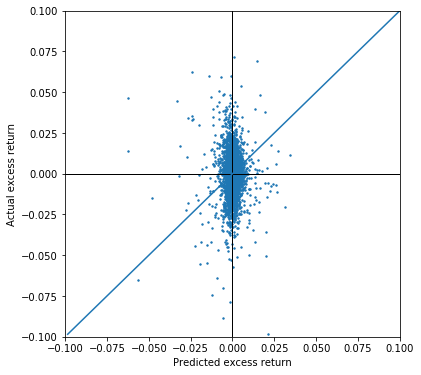

In [16]:
plt.figure(figsize=(6,6))
plt.axhline(lw=1,c='k')
plt.axvline(lw=1,c='k')
plt.scatter(pred,actual_ret,s=2)
x = np.linspace(min(actual_ret),max(actual_ret),50)
plt.plot(x,x)
plt.ylim(-0.1,0.1)
plt.xlim(-0.1,0.1)
plt.xlabel('Predicted excess return')
plt.ylabel('Actual excess return')

In [17]:
# mean_square_error
mse = np.mean((pred - actual_ret)**2)
mse

0.0002540843613192365

*Use the past 5 day's data to predict current daily excess return. (The rolling window is 5 days)*

In [18]:

min_periods = 5
inputs = df[['ret','lag_rv']]
wins = rollingwins(inputs,min_periods = min_periods)

pred = [regression(win)[0] for win in wins]
pred_df = pd.DataFrame(pred,index = df.index[min_periods :],columns=['pred_ret'])

Text(0, 0.5, 'Actual excess return')

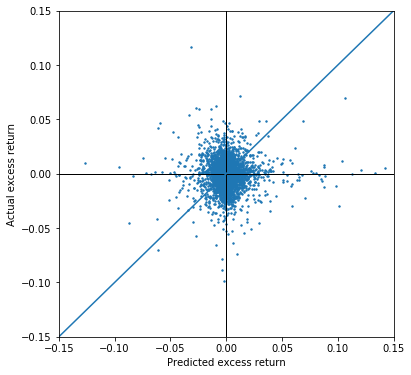

In [19]:
actual_ret = df.ret[min_periods :].values

plt.figure(figsize=(6,6))
plt.axhline(lw=1,c='k')
plt.axvline(lw=1,c='k')
plt.scatter(pred,actual_ret,s=2)
x = np.linspace(min(pred),max(pred),50)
plt.plot(x,x)
plt.ylim(-0.15,0.15)
plt.xlim(-0.15,0.15)
plt.xlabel('Predicted excess return')
plt.ylabel('Actual excess return')

In [20]:
# mean_square_error
mse = np.mean((pred - actual_ret)**2)
mse

0.0005667820403081629

#### 3. Examine the economic performance of a strategy whose weights are based on those out-of-sample forecasts.

Portfolio weight in the risky asset is based on the standard rule:
$$ y* = \frac{E(R)}{AVar(r)}$$ 
* Assume that A = 3

Details:
* The first forecast should be made on the last day of the year 2000, when I need to forecaste the first day of the year 2001. And use all data available prior to the day being forecasted.
* On each day, run the forecast regression, compute the predicted mean and variance using the last day of data in your sample.
* Use predictions to get y*, and calculate the excess return on the portfolio based on that y*.
* Compute the mean, standard deviation, and Sharpe ratio of the portfolio.

In [21]:
n = len(df['2000'])
y_star = []
for i in range(n-1,len(df)):
    regdata = df.iloc[:i]
    result_m = smf.ols('xret ~ lag_rv', data=regdata).fit()
    fc_m = result_m.params[0] + result_m.params[1]*df['lag_rv'].iloc[i]
    
    result_r2 = smf.ols('ret2 ~ lag_rv', data=regdata).fit()
    fc_r2 = result_r2.params[0] + result_r2.params[1]*df['lag_rv'].iloc[i]

    fc_v = fc_r2 - fc_m**2
          
    # According to the equation to calculate y*
    y = fc_m/(3*fc_v)
    y_star = np.hstack((y_star,y))
    

In [22]:
## We can make some changes here about the maximum weight and minimum weight

max_weight = 1.5
min_weight = 0.5

weight1 = define_weight(y_star,max_weight = 1.5,min_weight = 0.5 )

In [23]:
weight = pd.DataFrame(index = df.index[n:])
#weight_original = pd.DataFrame(y_star,columns=['weight_original']).shift()[1:]
#weight_limit = pd.DataFrame(weight_limit,columns=['weight_limit']).shift()[1:]
weight['weight_0'] = y_star[:-1]
weight['weight_1'] = weight1[:-1]
weight.head(5)

,weight_0,weight_1
Date,,
2001-01-02,-4.806752,0.500000
2001-01-03,-2.886851,0.500000
2001-01-04,0.559126,0.559126
2001-01-05,6.091148,1.500000
2001-01-08,-0.374034,0.500000


In [24]:
port = pd.DataFrame(index=df.index[n:])
port['spy_xret'] = df.xret[n:]
port['spy_ret'] = df.ret[n:]
port['spy_value'] = (1+port['spy_ret']).cumprod()

port['port0_ret'] = port['spy_ret']*weight['weight_0']
port['port1_ret'] = port['spy_ret']*weight['weight_1']

port['port0_xret'] = port['port0_ret'] - irx['Close'].shift()/252/100
port['port1_xret'] = port['port1_ret'] - irx['Close'].shift()/252/100

port['port0_value'] = (1+port['port0_ret']).cumprod()
port['port1_value'] = (1+port['port1_ret']).cumprod()

In [25]:
port.head()

,spy_xret,spy_ret,spy_value,port0_ret,port1_ret,port0_xret,port1_xret,port0_value,port1_value
Date,,,,,,,,,
2001-01-02,-0.018333,-0.018104,0.981896,0.087022,-0.009052,0.086795,-0.009279,1.087022,0.990948
2001-01-03,0.047808,0.048035,1.029061,-0.138669,0.024017,-0.138895,0.023792,0.936286,1.014748
2001-01-04,-0.010985,-0.010764,1.017984,-0.006018,-0.006018,-0.006238,-0.006238,0.930651,1.008641
2001-01-05,-0.032852,-0.032643,0.984755,-0.198831,-0.048964,-0.199039,-0.049172,0.745609,0.959254
2001-01-08,0.007542,0.007741,0.992377,-0.002895,0.003870,-0.003092,0.003673,0.743450,0.962966


In [26]:
describePerformance(port[['spy_xret','port1_xret']])

,spy_xret,port1_xret
mean,0.000279,0.000061
std,0.011839,0.009176
min,-0.098457,-0.147681
50%,0.000608,0.000290
max,0.145189,0.107251
ann_std,0.187190,0.145087
ann_ret (%),5.371267,0.466886
sharpe,0.373064,0.105088
fracpos,0.543770,0.540362
t score,1.616705,0.455408


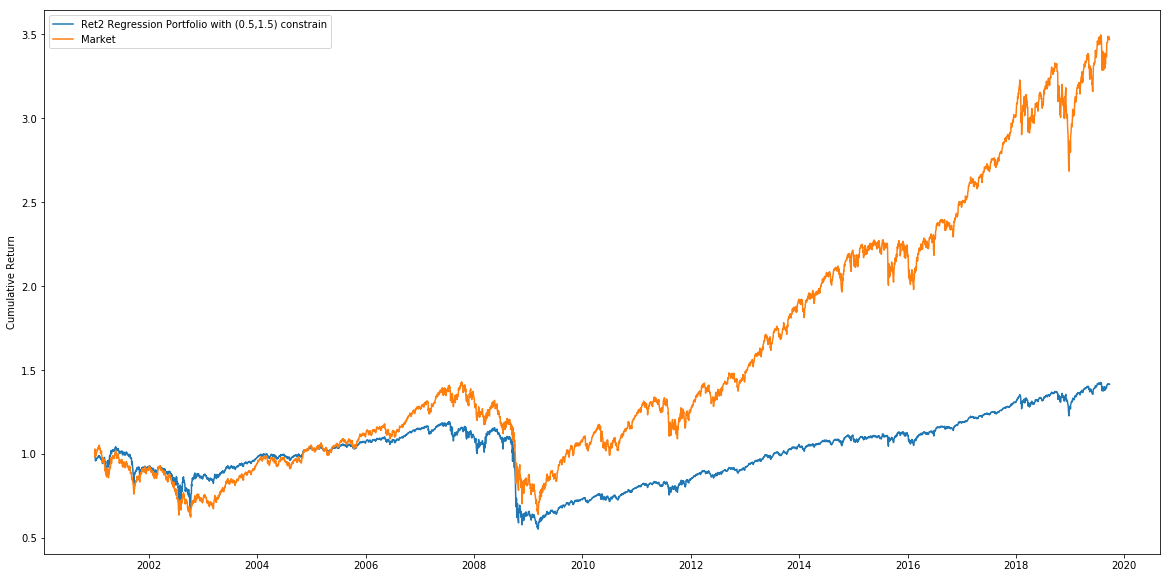

In [27]:
plt.figure(figsize=(20,10))
plt.plot(port['port1_value'],label='Ret2 Regression Portfolio with (0.5,1.5) constrain')
plt.plot(port['spy_value'],label='Market')
plt.ylabel('Cumulative Return')
plt.legend()

### Optional : Strategy 2:
Use vix2 in the forecast regression.

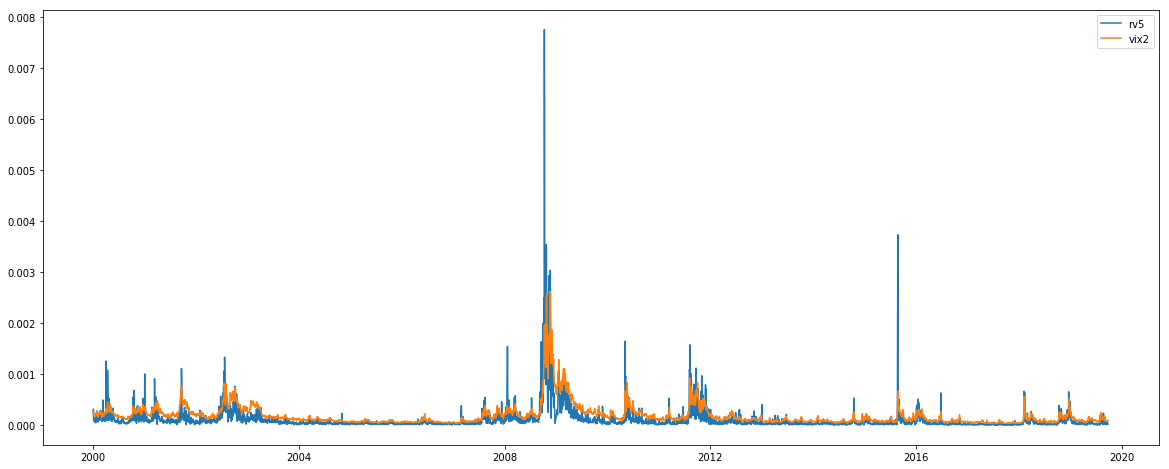

In [28]:
plt.figure(figsize=(20,8))
plt.plot(df['rv5'])
plt.plot(df['vix2'])
plt.legend()

In [29]:
n = len(df['2000'])
y_star2 = []
df['lag_vix2'] = df['vix2'].shift()
for i in range(n-1,len(df)):
    regdata2 = df.iloc[:i]
    result_m2 = smf.ols('xret ~ lag_vix2', data=regdata2).fit()
    fc_m2 = result_m2.params[0] + result_m2.params[1]*df['lag_vix2'].iloc[i]
    
    result_2_r2 = smf.ols('ret2 ~ lag_vix2', data=regdata2).fit()
    fc_2_r2 = result_2_r2.params[0] + result_2_r2.params[1]*df['lag_vix2'].iloc[i]

    fc_v2 = fc_2_r2 - fc_m2**2
          
    # According to the equation to calculate y*
    y2 = fc_m2/(3*fc_v2)
    y_star2 = np.hstack((y_star2,y2))
    

In [30]:
weight2 = define_weight(y_star2,1.5,0.5)
weight['weight_2'] = weight2[:-1]

port['port2_ret'] = port['spy_ret']*weight2[:-1]
port['port2_xret'] = port['port2_ret'] - irx['Close'].shift()/252/100
port['port2_value'] = (port['port2_ret']+1).cumprod()

In [31]:
port.loc[port['port2_ret'].idxmax()]

spy_xret       0.059596
spy_ret        0.059662
spy_value      0.673253
port0_ret      0.269134
port1_ret      0.089493
port0_xret     0.269068
port1_xret     0.089427
port0_value    1.130512
port1_value    0.730289
port2_ret      0.089493
port2_xret     0.089427
port2_value    0.811909
Name: 2002-07-24 00:00:00, dtype: float64

In [32]:
port.head()

,spy_xret,spy_ret,spy_value,port0_ret,port1_ret,port0_xret,port1_xret,port0_value,port1_value,port2_ret,port2_xret,port2_value
Date,,,,,,,,,,,,
2001-01-02,-0.018333,-0.018104,0.981896,0.087022,-0.009052,0.086795,-0.009279,1.087022,0.990948,-0.023734,-0.023961,0.976266
2001-01-03,0.047808,0.048035,1.029061,-0.138669,0.024017,-0.138895,0.023792,0.936286,1.014748,0.060734,0.060508,1.035559
2001-01-04,-0.010985,-0.010764,1.017984,-0.006018,-0.006018,-0.006238,-0.006238,0.930651,1.008641,-0.016146,-0.016365,1.018839
2001-01-05,-0.032852,-0.032643,0.984755,-0.198831,-0.048964,-0.199039,-0.049172,0.745609,0.959254,-0.047305,-0.047513,0.970642
2001-01-08,0.007542,0.007741,0.992377,-0.002895,0.003870,-0.003092,0.003673,0.743450,0.962966,0.011611,0.011414,0.981912


In [33]:
describePerformance(port[['spy_xret','port1_xret','port2_xret']])

,spy_xret,port1_xret,port2_xret
mean,0.000279,0.000061,0.000158
std,0.011839,0.009176,0.009162
min,-0.098457,-0.147681,-0.083532
50%,0.000608,0.000290,0.000367
max,0.145189,0.107251,0.089427
ann_std,0.187190,0.145087,0.144865
ann_ret (%),5.371267,0.466886,2.950705
sharpe,0.373064,0.105088,0.273248
fracpos,0.543770,0.540362,0.541214
t score,1.616705,0.455408,1.184145


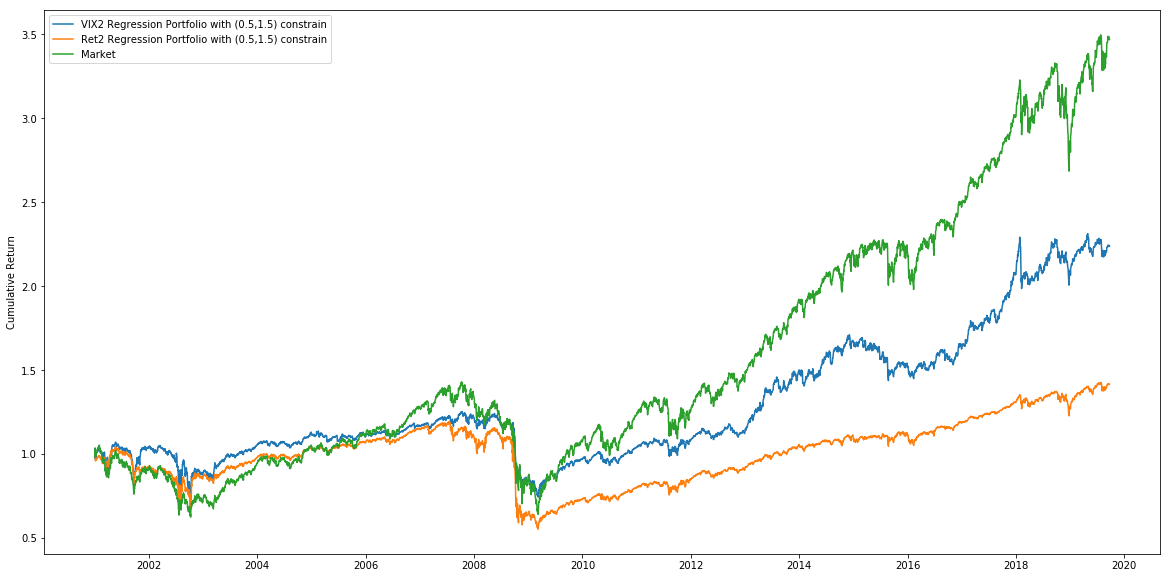

In [34]:
plt.figure(figsize=(20,10))
plt.plot(port['port2_value'],label='VIX2 Regression Portfolio with (0.5,1.5) constrain')
plt.plot(port['port1_value'],label='Ret2 Regression Portfolio with (0.5,1.5) constrain')
plt.plot(port['spy_value'],label='Market')
plt.ylabel('Cumulative Return')
plt.legend()

In [35]:
weight.head()

,weight_0,weight_1,weight_2
Date,,,
2001-01-02,-4.806752,0.500000,1.310940
2001-01-03,-2.886851,0.500000,1.264370
2001-01-04,0.559126,0.559126,1.500000
2001-01-05,6.091148,1.500000,1.449187
2001-01-08,-0.374034,0.500000,1.500000


### Optional: Strategy3
Use multiple lags in the forecast regression.

Lag Correlation

In [36]:
print('Correlation between ret ~ lag1_rv is %f' % df['ret'].corr(df['lag_rv']))
print('Correlation between ret ~ lag2_rv is %f' % df['ret'].corr(df['lag_rv'].shift()))
print('Correlation between ret ~ lag3_rv is %f' % df['ret'].corr(df['lag_rv'].shift(2)))
print('Correlation between ret2 ~ lag1_rv is %f' % df['ret2'].corr(df['lag_rv']))
print('Correlation between ret2 ~ lag2_rv is %f' % df['ret2'].corr(df['lag_rv'].shift()))
print('Correlation between ret2 ~ lag3_rv is %f' % df['ret2'].corr(df['lag_rv'].shift(2)))
print('Correlation between ret2 ~ lag4_rv is %f' % df['ret2'].corr(df['lag_rv'].shift(3)))

Correlation between ret ~ lag1_rv is 0.064593
Correlation between ret ~ lag2_rv is 0.068174
Correlation between ret ~ lag3_rv is -0.010097
Correlation between ret2 ~ lag1_rv is 0.614398
Correlation between ret2 ~ lag2_rv is 0.419480
Correlation between ret2 ~ lag3_rv is 0.501591
Correlation between ret2 ~ lag4_rv is 0.343915


In [37]:
print('Correlation between ret ~ lag1_rv is %f' % df['ret'].corr(df['lag_vix2']))
print('Correlation between ret ~ lag2_rv is %f' % df['ret'].corr(df['lag_vix2'].shift()))
print('Correlation between ret ~ lag3_rv is %f' % df['ret'].corr(df['lag_vix2'].shift(2)))
print('Correlation between ret2 ~ lag1_rv is %f' % df['ret2'].corr(df['lag_vix2']))
print('Correlation between ret2 ~ lag2_rv is %f' % df['ret2'].corr(df['lag_vix2'].shift()))
print('Correlation between ret2 ~ lag3_rv is %f' % df['ret2'].corr(df['lag_vix2'].shift(2)))

Correlation between ret ~ lag1_rv is 0.051431
Correlation between ret ~ lag2_rv is 0.031295
Correlation between ret ~ lag3_rv is 0.010950
Correlation between ret2 ~ lag1_rv is 0.502821
Correlation between ret2 ~ lag2_rv is 0.471878
Correlation between ret2 ~ lag3_rv is 0.450042


According to those correlations, we will choose lag_rv, lag2_rv and lag3_rv to forecast the volatility, and lag_rv and lag2_rv to forecast the return

In [38]:
n = len(df['2000'])
y_star3 = []
df['lag2_rv'] = df['lag_rv'].shift()
df['lag3_rv'] = df['lag_rv'].shift(2)
for i in range(n-1,len(df)):
    regdata3 = df.iloc[:i]
    result_m3 = smf.ols('xret ~ lag_rv + lag2_rv', data=regdata3).fit()
    fc_m3 = result_m3.params[0] + result_m3.params[1]*df['lag_rv'].iloc[i] + result_m3.params[2]*df['lag2_rv'].iloc[i]
    
    result_3_r2 = smf.ols('ret2 ~ lag_rv + lag2_rv + lag3_rv', data=regdata3).fit()
    fc_3_r2 = result_3_r2.predict(df.iloc[i])
    
    fc_v3 = fc_3_r2 - fc_m3**2
          
    # According to the equation to calculate y*
    y3 = fc_m3/(3*fc_v3)
    y_star3 = np.hstack((y_star3,y3))

In [39]:
weight3 = define_weight(y_star3,1.5,0.5)
weight['weight_3'] = weight3[:-1]

port['port3_ret'] = port['spy_ret']*weight3[:-1]
port['port3_xret'] = port['port3_ret'] - irx['Close'].shift()/252/100
port['port3_value'] = (port['port3_ret']+1).cumprod()

In [40]:
port.head()

,spy_xret,spy_ret,spy_value,port0_ret,port1_ret,port0_xret,port1_xret,port0_value,port1_value,port2_ret,port2_xret,port2_value,port3_ret,port3_xret,port3_value
Date,,,,,,,,,,,,,,,
2001-01-02,-0.018333,-0.018104,0.981896,0.087022,-0.009052,0.086795,-0.009279,1.087022,0.990948,-0.023734,-0.023961,0.976266,-0.009052,-0.009279,0.990948
2001-01-03,0.047808,0.048035,1.029061,-0.138669,0.024017,-0.138895,0.023792,0.936286,1.014748,0.060734,0.060508,1.035559,0.024017,0.023792,1.014748
2001-01-04,-0.010985,-0.010764,1.017984,-0.006018,-0.006018,-0.006238,-0.006238,0.930651,1.008641,-0.016146,-0.016365,1.018839,-0.005382,-0.005601,1.009287
2001-01-05,-0.032852,-0.032643,0.984755,-0.198831,-0.048964,-0.199039,-0.049172,0.745609,0.959254,-0.047305,-0.047513,0.970642,-0.048964,-0.049172,0.959868
2001-01-08,0.007542,0.007741,0.992377,-0.002895,0.003870,-0.003092,0.003673,0.743450,0.962966,0.011611,0.011414,0.981912,0.003870,0.003673,0.963583


In [41]:
describePerformance(port[['spy_xret','port1_xret','port2_xret','port3_xret']])

,spy_xret,port1_xret,port2_xret,port3_xret
mean,0.000279,0.000061,0.000158,0.000085
std,0.011839,0.009176,0.009162,0.009441
min,-0.098457,-0.147681,-0.083532,-0.147681
50%,0.000608,0.000290,0.000367,0.000308
max,0.145189,0.107251,0.089427,0.094350
ann_std,0.187190,0.145087,0.144865,0.149279
ann_ret (%),5.371267,0.466886,2.950705,1.007163
sharpe,0.373064,0.105088,0.273248,0.142171
fracpos,0.543770,0.540362,0.541214,0.540788
t score,1.616705,0.455408,1.184145,0.616113


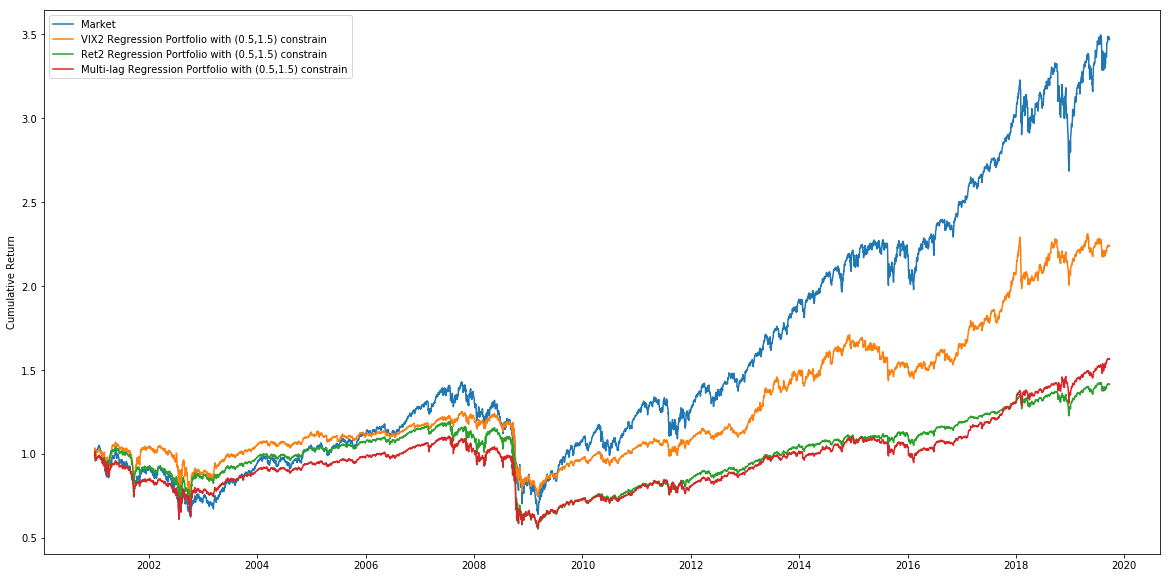

In [42]:
plt.figure(figsize=(20,10))
plt.plot(port['spy_value'],label='Market')
plt.plot(port['port2_value'],label='VIX2 Regression Portfolio with (0.5,1.5) constrain')
plt.plot(port['port1_value'],label='Ret2 Regression Portfolio with (0.5,1.5) constrain')
plt.plot(port['port3_value'],label='Multi-lag Regression Portfolio with (0.5,1.5) constrain')
plt.ylabel('Cumulative Return')
plt.legend()

###  Optional: Strategy 3(a)
multiple lag regression: log_xret , log_rv

In [43]:
n = len(df['2000'])
y_star3a = []
df['lag_ret'] = df['ret'].shift()
for i in range(n-1,len(df)):
    regdata3a = df.iloc[:i]
    result_m3a = smf.ols('xret ~ lag_rv + lag_ret', data=regdata3a).fit()
    fc_m3a = result_m3a.params[0] + result_m3a.params[1]*df['lag_rv'].iloc[i] + result_m3a.params[2]*df['lag_ret'].iloc[i]
    
    result_3a_r2 = smf.ols('ret2 ~ lag_rv + lag_ret', data=regdata3a).fit()
    fc_3a_r2 = result_3a_r2.predict(df.iloc[i])
    
    fc_v3a = fc_3a_r2 - fc_m3a**2
          
    # According to the equation to calculate y*
    y3a = fc_m3a/(3*fc_v3)
    y_star3a = np.hstack((y_star3a,y3a))

In [44]:
weight3a = define_weight(y_star3a,1.5,0.5)
weight['weight_3a'] = weight3a[:-1]

port['port3a_ret'] = port['spy_ret']*weight3a[:-1]
port['port3a_xret'] = port['port3a_ret'] - irx['Close'].shift()/252/100
port['port3a_value'] = (port['port3a_ret']+1).cumprod()

###  Optional: Strategy 3(a)
multiple lag regression: log_xret , log_rv
* ret ~ lag_rv + lag_ret
* ret2 ~ lag_rv + lag_vix2

In [45]:
n = len(df['2000'])
y_star3b = []
for i in range(n-1,len(df)):
    regdata3b = df.iloc[:i]
    result_m3b = smf.ols('xret ~ lag_rv + lag_ret', data=regdata3b).fit()
    fc_m3b = result_m3b.params[0] + result_m3b.params[1]*df['lag_rv'].iloc[i] + result_m3b.params[2]*df['lag_ret'].iloc[i]
    
    result_3b_r2 = smf.ols('ret2 ~ lag_rv + lag_vix2', data=regdata3b).fit()
    fc_3b_r2 = result_3b_r2.predict(df.iloc[i])
    
    fc_v3b = fc_3b_r2 - fc_m3b**2
          
    # According to the equation to calculate y*
    y3b = fc_m3b/(3*fc_v3)
    y_star3b = np.hstack((y_star3b,y3b))

In [46]:
weight3b = define_weight(y_star3a,1.5,0.5)
weight['weight_3b'] = weight3b[:-1]

port['port3b_ret'] = port['spy_ret']*weight3b[:-1]
port['port3b_xret'] = port['port3b_ret'] - irx['Close'].shift()/252/100
port['port3b_value'] = (port['port3b_ret']+1).cumprod()

### Optional: Strategy 4
Use moving averages of realized variance with expanding windows in the forecast regression.

In [47]:
n = len(df['2000'])
y_star4 = []
df['rv_moving_a_expa'] = df['rv5'].expanding().mean()

for i in range(n-1,len(df)):
    regdata4 = df.iloc[:i]
    result_m4 = smf.ols('xret ~ rv_moving_a_expa', data=regdata4).fit()
    fc_m4 = result_m4.params[0] + result_m4.params[1]*df['rv_moving_a_expa'].iloc[i]
    
    result_4_r2 = smf.ols('ret2 ~ rv_moving_a_expa', data=regdata4).fit()
    fc_4_r2 = result_4_r2.predict(df.iloc[i])
    
    fc_v4 = fc_4_r2 - fc_m4**2
          
    # According to the equation to calculate y*
    y4 = fc_m4/(3*fc_v4)
    y_star4 = np.hstack((y_star4,y4))

In [48]:
weight4 = define_weight(y_star4,1.5,0.5)
weight['weight_4'] = weight4[:-1]

port['port4_ret'] = port['spy_ret']*weight4[:-1]
port['port4_xret'] = port['port4_ret'] - irx['Close'].shift()/252/100
port['port4_value'] = (port['port4_ret']+1).cumprod()

### Optional: Strategy 5
Use moving averages of realized variance with fixed windows in the forecast regression. (Rolling based)

In [49]:
n = len(df['2000'])
y_star5 = []
df['rv_moving_a_rolling'] = df['rv5'].rolling(window=250).mean()

# Start to do regression after 2000-12-29
for i in range(n-1,len(df)):
    
    # At the first day of 2001, it's not good to use one day data to do regression
    # I prefer to do regression using rolling moving average when we have at lease 30 rows with rolling average data.
    # During the first 30 days, I will use expanding window moving average to do forecast.
    if i < n+29:
        regdata5 = df.iloc[:i]
        result_m5 = smf.ols('xret ~ rv_moving_a_expa', data=regdata5).fit()
        fc_m5 = result_m5.params[0] + result_m5.params[1]*df['rv_moving_a_expa'].iloc[i]

        result_5_r2 = smf.ols('ret2 ~ rv_moving_a_expa', data=regdata5).fit()
        fc_5_r2 = result_5_r2.predict(df.iloc[i])

    else:
        regdata5 = df.iloc[n-1:i]
        result_m5 = smf.ols('ret ~ rv_moving_a_rolling', data=regdata5).fit()
        fc_m5 = result_m5.params[0] + result_m5.params[1]*df['rv_moving_a_rolling'].iloc[i]

        result_5_r2 = smf.ols('ret2 ~ rv_moving_a_rolling', data=regdata5).fit()
        fc_5_r2 = result_5_r2.predict(df.iloc[i])

    fc_v5 = fc_5_r2 - fc_m5**2
          
    # According to the equation to calculate y*
    y5 = fc_m5/(3*fc_v5)
    y_star5 = np.hstack((y_star5,y5))

In [50]:
weight5 = define_weight(y_star5,1.5,0.5)
weight['weight_5'] = weight5[:-1]

port['port5_ret'] = port['spy_ret']*weight5[:-1]
port['port5_xret'] = port['port5_ret'] - irx['Close'].shift()/252/100
port['port5_value'] = (port['port5_ret']+1).cumprod()

## Performance Summary

In [51]:
describePerformance(port[['spy_xret','port1_xret','port2_xret','port3_xret','port3a_xret','port3b_xret','port4_xret','port5_xret']])

,spy_xret,port1_xret,port2_xret,port3_xret,port3a_xret,port3b_xret,port4_xret,port5_xret
mean,0.000279,0.000061,0.000158,0.000085,0.000229,0.000229,0.000099,0.000158
std,0.011839,0.009176,0.009162,0.009441,0.013552,0.013552,0.006132,0.008501
min,-0.098457,-0.147681,-0.083532,-0.147681,-0.147681,-0.147681,-0.058787,-0.062791
50%,0.000608,0.000290,0.000367,0.000308,0.000311,0.000311,0.000287,0.000350
max,0.145189,0.107251,0.089427,0.094350,0.217788,0.217788,0.072590,0.072590
ann_std,0.187190,0.145087,0.144865,0.149279,0.214273,0.214273,0.096953,0.134411
ann_ret (%),5.371267,0.466886,2.950705,1.007163,3.492867,3.492867,2.029308,3.088985
sharpe,0.373064,0.105088,0.273248,0.142171,0.266725,0.266725,0.255719,0.293628
fracpos,0.543770,0.540362,0.541214,0.540788,0.541001,0.541001,0.541640,0.543131
t score,1.616705,0.455408,1.184145,0.616113,1.155878,1.155878,1.108181,1.272463


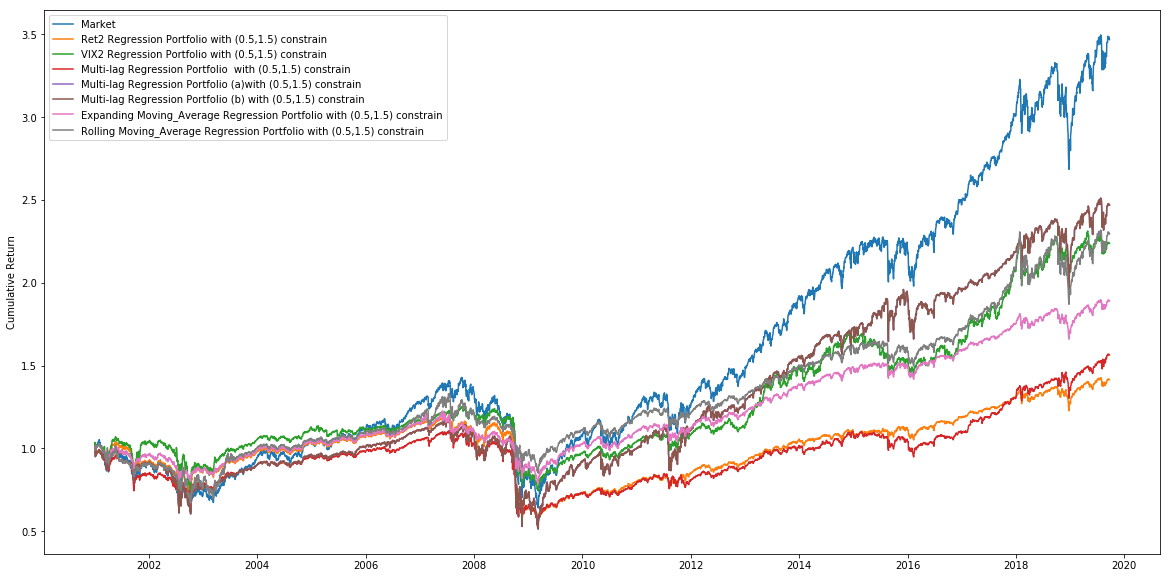

In [52]:
plt.figure(figsize=(20,10))
plt.plot(port['spy_value'],label='Market')
plt.plot(port['port1_value'],label='Ret2 Regression Portfolio with (0.5,1.5) constrain')
plt.plot(port['port2_value'],label='VIX2 Regression Portfolio with (0.5,1.5) constrain')
plt.plot(port['port3_value'],label='Multi-lag Regression Portfolio  with (0.5,1.5) constrain')
plt.plot(port['port3a_value'],label='Multi-lag Regression Portfolio (a)with (0.5,1.5) constrain')
plt.plot(port['port3b_value'],label='Multi-lag Regression Portfolio (b) with (0.5,1.5) constrain')
plt.plot(port['port4_value'],label='Expanding Moving_Average Regression Portfolio with (0.5,1.5) constrain')
plt.plot(port['port5_value'],label='Rolling Moving_Average Regression Portfolio with (0.5,1.5) constrain')
plt.ylabel('Cumulative Return')
plt.legend()

In [53]:
port.head()

,spy_xret,spy_ret,spy_value,port0_ret,port1_ret,port0_xret,port1_xret,port0_value,port1_value,port2_ret,...,port3a_value,port3b_ret,port3b_xret,port3b_value,port4_ret,port4_xret,port4_value,port5_ret,port5_xret,port5_value
Date,,,,,,,,,,,,,,,,,,,,,
2001-01-02,-0.018333,-0.018104,0.981896,0.087022,-0.009052,0.086795,-0.009279,1.087022,0.990948,-0.023734,...,0.990948,-0.009052,-0.009279,0.990948,-0.009052,-0.009279,0.990948,-0.009052,-0.009279,0.990948
2001-01-03,0.047808,0.048035,1.029061,-0.138669,0.024017,-0.138895,0.023792,0.936286,1.014748,0.060734,...,1.014748,0.024017,0.023792,1.014748,0.024017,0.023792,1.014748,0.024017,0.023792,1.014748
2001-01-04,-0.010985,-0.010764,1.017984,-0.006018,-0.006018,-0.006238,-0.006238,0.930651,1.008641,-0.016146,...,0.998364,-0.016146,-0.016365,0.998364,-0.005382,-0.005601,1.009287,-0.005382,-0.005601,1.009287
2001-01-05,-0.032852,-0.032643,0.984755,-0.198831,-0.048964,-0.199039,-0.049172,0.745609,0.959254,-0.047305,...,0.949480,-0.048964,-0.049172,0.949480,-0.016321,-0.016529,0.992814,-0.016321,-0.016529,0.992814
2001-01-08,0.007542,0.007741,0.992377,-0.002895,0.003870,-0.003092,0.003673,0.743450,0.962966,0.011611,...,0.960504,0.011611,0.011414,0.960504,0.003870,0.003673,0.996656,0.003870,0.003673,0.996656
